In [1]:
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
def regression (xnot,ynot,xxx,yyy):
    yval = [] 
    xval = [] 
    totdays = len(xxx) -2
    if totdays-xnot>3:
        for days in range(0,totdays):
            xval.append(xxx[days])
            if yyy[days]!=0:
                ystr = yyy[days]/ynot
                yval.append(np.log(ystr))
            else:
                yval.append(1)
        (slope, intercept, r, a, b)=stats.linregress(xval, yval)
    else:
        slope = 0
        r=0
    return slope,r*r

In [4]:
def cleaning (dirty,var_cln):
    for st in states.index:
        hold = dirty[st]
        for cnt in hold:
            new_var = var_cln+'I'
            hold[cnt].update({new_var:[hold[cnt][var_cln][0]]})
            if len(hold[cnt][var_cln]) > 2:
                for x in np.arange(1,len(hold[cnt][var_cln])-1,1):
                    hold[cnt][new_var].append((hold[cnt][var_cln][x-1]+hold[cnt][var_cln][x]+hold[cnt][var_cln][x+1])/3)
                hold[cnt][new_var].append(hold[cnt][var_cln][x+1])


In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df = pd.DataFrame(data)
df.head()
dfar = df.loc[df['county']== 'New York City']
dfar.head()   

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
565,2020-03-05,New York City,New York,NaN,4,0


In [6]:
df['date'] = pd.to_datetime(df['date'])
states = df['state'].value_counts()

In [7]:
#Build raw data dictionary for county derivitive vs days
exponential={}
for st in states.index:
    state = df.loc[df['state']==st]
    counties = state['county'].value_counts()
    exponential.update( {st : {}} )
    for cnt in counties.index:
        county = state.loc[(df['county'] == cnt)]
        yprev = 0
        exponential[st].update({cnt:{}})
        exponential[st][cnt].update( {'xval' : []})
        exponential[st][cnt].update({'delta' :[]})
        days=0
        for y,z in county.iterrows(): 
            ycur = z['cases']
            dif = ycur - yprev
            exponential[st][cnt]['delta'].append(dif)
            exponential[st][cnt]['xval'].append(days)
            days=days+1
            yprev = ycur
        
    

In [8]:
cleaning(exponential,'delta')
cleaning(exponential,'deltaI')
cleaning(exponential,'deltaII')
cleaning(exponential,'deltaIII')
cleaning(exponential,'deltaIIII')
cleaning(exponential,'deltaIIIII')

In [9]:
#build raw data dictionary for county cases vs days
population={}
for st in states.index:
    state = df.loc[df['state']==st]
    counties = state['county'].value_counts()
    population.update( {st : {}} )
    for cnt in counties.index:
        county = state.loc[(df['county'] == cnt)]
        population[st].update({cnt:{}})
        population[st][cnt].update( {'xval' : []})
        population[st][cnt].update({'cases' :[]})
        days=0
        for y,z in county.iterrows(): 
            ycur = z['cases']
            population[st][cnt]['cases'].append(ycur)
            population[st][cnt]['xval'].append(days)
            days=days+1

In [10]:
cleaning(population, 'cases')   #data cleaning see box 4
cleaning(population, 'casesI')

In [11]:
#code for building a dictionary to be passed into a dataframe
direct_tau = {'State':[],'County':[],'Ynot':[],'First Doubling':[], 'Current Total':[],
              'Inv Tau':[],'Tau':[],'R Squared':[],'Days In':[], 'ID':[]}
for st in states.index:
    test = population[st]  #pass each state dictionary into holding dictionary
    for cnt in test:
        day=0
        test2 = test[cnt]  #pass each county dictionary into holding dictionary
        start =test2['cases'][0]
        for x in np.arange(1, len(test2['casesII']),1):  #iterate through days to test for thresh hold
            if test2['casesII'][x]>=2*start:
                day = x
                start =test2['cases'][x]
                invtau,rr = regression(0,start,test2['xval'],test2['casesII']) #regression analysis(see box 3)
                direct_tau['State'].append(st)
                direct_tau['County'].append(cnt)
                direct_tau['Ynot'].append(start)
                direct_tau['First Doubling'].append(day)
                direct_tau['Current Total'].append(test2['cases'][len(test2['cases'])-1])
                direct_tau['Inv Tau'].append(invtau)
                direct_tau['Days In'].append(len(test2['cases'])-1)
                if invtau != 0:
                    direct_tau['Tau'].append(1/invtau)
                else:
                    direct_tau['Tau'].append(0)
                direct_tau['R Squared'].append(rr)
                fips_hold=df.loc[(df['county']==cnt)&(df['state']==st)]
                fips_hold=fips_hold.reset_index()
                direct_tau['ID'].append(fips_hold['fips'][0])
                break

In [12]:
direct_df=pd.DataFrame(direct_tau)
direct_df = direct_df.sort_values('Inv Tau', ascending =False)
direct_df.to_csv('../output_data/county_metrics')
direct_df.head()

,State,County,Ynot,First Doubling,Current Total,Inv Tau,Tau,R Squared,Days In,ID
1502,Iowa,Louisa,1,1,149,0.467223,2.140306,0.928822,11,19115.0
2033,Nebraska,Custer,3,2,19,0.462357,2.162831,0.994087,8,31041.0
2072,West Virginia,Wayne,17,2,60,0.419596,2.383245,0.956164,5,54099.0
982,Kentucky,Whitley,1,2,5,0.384896,2.598101,0.990889,6,21235.0
1691,Minnesota,Pine,3,2,6,0.361583,2.765615,0.948092,6,27115.0


In [14]:
NC_direct = direct_df.loc[direct_df['State']=='North Carolina']
NC_direct.to_csv('../output_data/NCcounty_metrics')
NC_direct.head()

,State,County,Ynot,First Doubling,Current Total,Inv Tau,Tau,R Squared,Days In,ID
588,North Carolina,Dare,1,3,12,0.272871,3.664739,0.943459,12,37055.0
579,North Carolina,Columbus,2,3,37,0.257031,3.890583,0.982388,16,37047.0
543,North Carolina,Granville,3,5,97,0.255312,3.916774,0.968365,23,37077.0
599,North Carolina,Jones,7,3,7,0.250193,3.996920,0.983702,5,37103.0
597,North Carolina,Pender,2,2,5,0.222826,4.487798,0.966773,9,37141.0


In [15]:
county_tau = {'State':[],'County':[],'First Doubling':[], 'Last Delta':[],
              'Inv Tau':[],'Tau':[],'R Squared':[],'ID':[]}
for st in states.index:
    test = exponential[st]
    for cnt in test:
        day=0
        test2 = test[cnt]
        for x in np.arange(1, len(test2['deltaIII']),1):
            if test2['deltaIII'][x]>4:
                day = x
                invtau,rr = regression(day,test2['deltaIII'][x],test2['xval'],test2['deltaIII']) 
                county_tau['State'].append(st)
                county_tau['County'].append(cnt)
                county_tau['First Doubling'].append(day)
                county_tau['Last Delta'].append(test2['delta'][len(test2['delta'])-1])
                county_tau['Inv Tau'].append(invtau)
                if invtau != 0:
                    county_tau['Tau'].append(1/invtau)
                else:
                    county_tau['Tau'].append(0)
                county_tau['R Squared'].append(rr)
                fips_hold=df.loc[(df['county']==cnt)&(df['state']==st)]
                fips_hold=fips_hold.reset_index()
                county_tau['ID'].append(fips_hold['fips'][0])
                break


C:\Users\littl\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\littl\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\littl\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\littl\Anaconda3\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [16]:
deriv_df=pd.DataFrame(county_tau)
deriv_df=deriv_df.sort_values('Inv Tau', ascending =False)
deriv_df.to_csv('../output_data/derivitivedata')
deriv_df.head()


,State,County,First Doubling,Last Delta,Inv Tau,Tau,R Squared,ID
516,Iowa,Louisa,3,70,0.292979,3.413215,0.889232,19115.0
657,New Jersey,Union,7,629,0.229464,4.357973,0.859099,34039.0
654,New Jersey,Passaic,9,488,0.228986,4.367086,0.870551,34031.0
396,New York,New York City,7,3701,0.228973,4.367333,0.833007,NaN
443,Pennsylvania,Luzerne,8,77,0.224058,4.463132,0.838860,42079.0


In [17]:
NC_deriv = deriv_df.loc[deriv_df['State']=='North Carolina']
NC_deriv.to_csv('../output_data/NCderivitivedata')

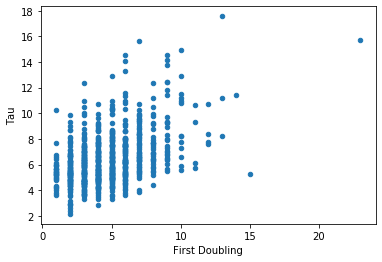

In [18]:
hold_df = direct_df.loc[direct_df['R Squared']>.95]
hold_df.plot('First Doubling','Tau', kind ='scatter')
# plt.xlim(0,500)
# plt.ylim(0,40)

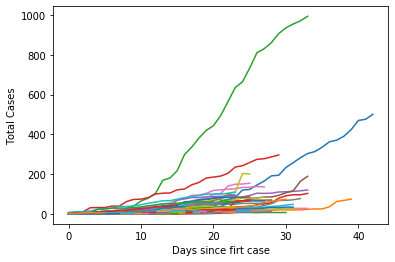

<Figure size 432x288 with 0 Axes>

In [19]:
state = 'North Carolina'
test =population[state]
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['cases'])
plt.xlabel('Days since firt case')
plt.ylabel('Total Cases')
plt.show()
plt.savefig(f'../output_data/{state}_raw.png')

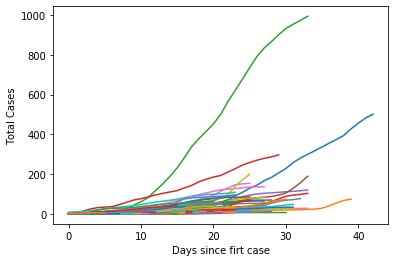

In [20]:
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['casesI'])
plt.xlabel('Days since firt case')
plt.ylabel('Total Cases')
plt.savefig(f'../output_data/{state}_clnI.png')
plt.show()

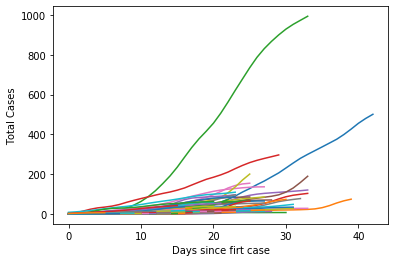

In [21]:
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['casesII'])
plt.xlabel('Days since firt case')
plt.ylabel('Total Cases')
plt.savefig(f'../output_data/{state}_clnII.png')
plt.show()

Wake County
   index           State County  Ynot  First Doubling  Current Total  \
0    509  North Carolina   Wake     1               5            501   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.161575  6.189093   0.960617       42  37183.0  


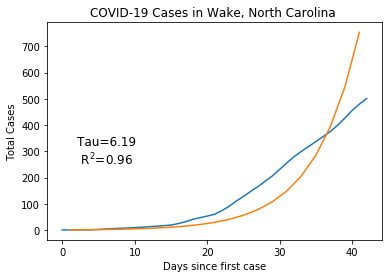

Chatham County
   index           State   County  Ynot  First Doubling  Current Total  \
0    510  North Carolina  Chatham     3              12             75   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.119776  8.348905    0.95917       39  37037.0  


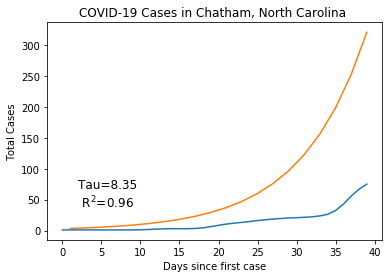

Mecklenburg County
   index           State       County  Ynot  First Doubling  Current Total  \
0    511  North Carolina  Mecklenburg     4               4            993   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.209937  4.763333    0.90121       33  37119.0  


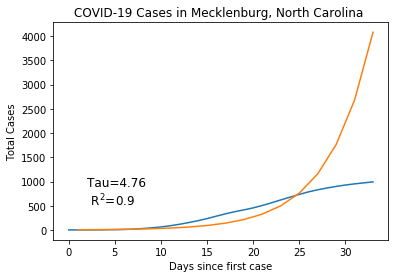

Johnston County
   index           State    County  Ynot  First Doubling  Current Total  \
0    512  North Carolina  Johnston     2               4            104   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.149056  6.708888   0.985157       33  37101.0  


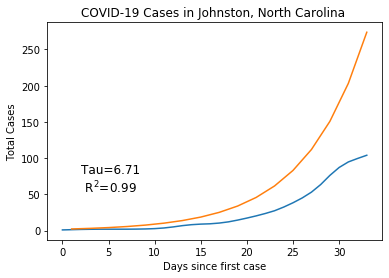

Forsyth County
   index           State   County  Ynot  First Doubling  Current Total  \
0    513  North Carolina  Forsyth     7               8            121   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.156598  6.385758   0.960941       33  37067.0  


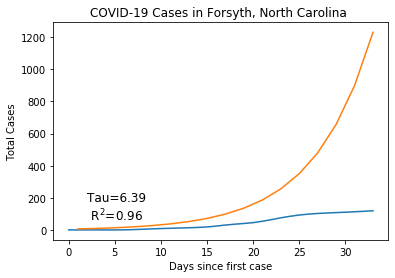

Cabarrus County
   index           State    County  Ynot  First Doubling  Current Total  \
0    514  North Carolina  Cabarrus     2               9            190   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.187165  5.342888   0.942984       33  37025.0  


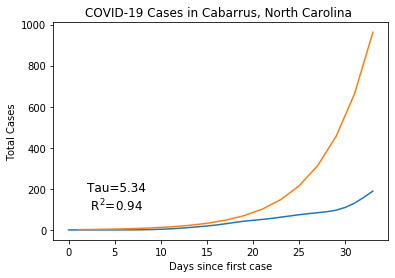

Onslow County
   index           State  County  Ynot  First Doubling  Current Total  \
0    515  North Carolina  Onslow     3              12             29   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.132042  7.573376   0.958372       33  37133.0  


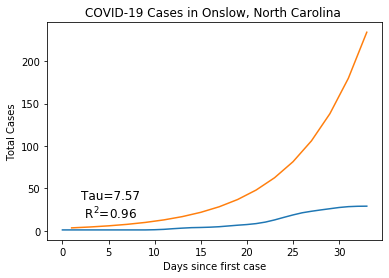

Wayne County
   index           State County  Ynot  First Doubling  Current Total  \
0    516  North Carolina  Wayne     1              13             78   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.157315  6.356681    0.91614       32  37191.0  


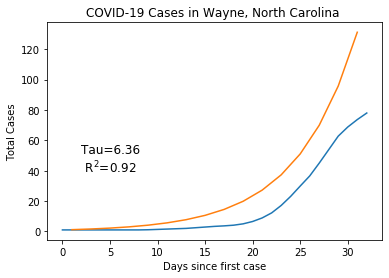

Craven County
   index           State  County  Ynot  First Doubling  Current Total  \
0    517  North Carolina  Craven     2               8             29   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.126346  7.914788   0.988263       31  37049.0  


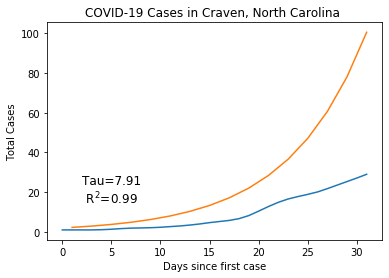

Harnett County
   index           State   County  Ynot  First Doubling  Current Total  \
0    518  North Carolina  Harnett     4               4             49   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.100193  9.980763   0.964326       31  37085.0  


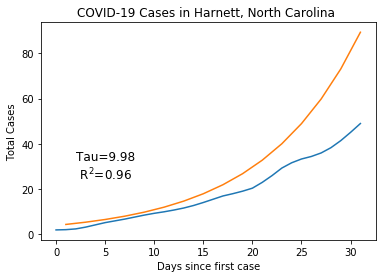

Brunswick County
   index           State     County  Ynot  First Doubling  Current Total  \
0    519  North Carolina  Brunswick     2               5             35   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.126588  7.899632   0.914066       31  37019.0  


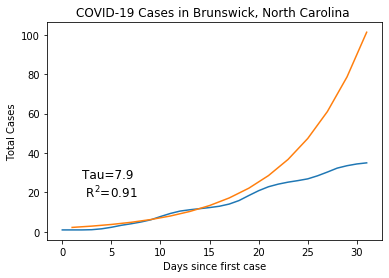

Wilson County
   index           State  County  Ynot  First Doubling  Current Total  \
0    520  North Carolina  Wilson     2               6             74   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.157593  6.345442   0.990224       30  37195.0  


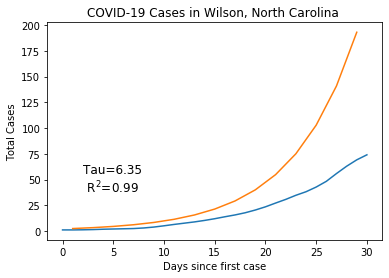

Watauga County
   index           State   County  Ynot  First Doubling  Current Total  \
0    521  North Carolina  Watauga     2               6              8   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.080779  12.379417   0.926859       30  37189.0  


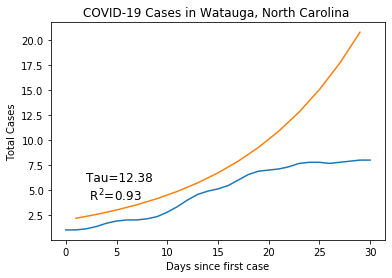

Durham County
   index           State  County  Ynot  First Doubling  Current Total  \
0    522  North Carolina  Durham     1               1            297   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.135116  7.401044   0.774277       29  37063.0  


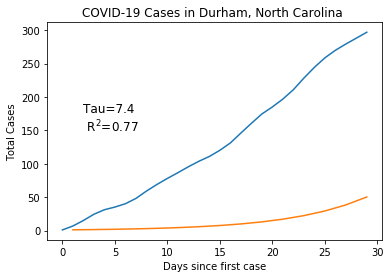

Sampson County
   index           State   County  Ynot  First Doubling  Current Total  \
0    523  North Carolina  Sampson     2              19             13   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.091476  10.931783   0.695019       28  37163.0  


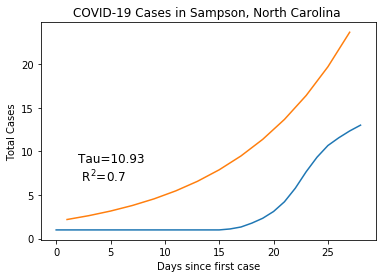

Iredell County
   index           State   County  Ynot  First Doubling  Current Total  \
0    524  North Carolina  Iredell     2               3             71   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.156745  6.379789   0.919098       28  37097.0  


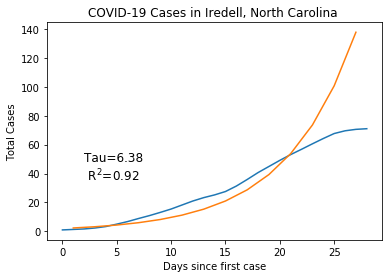

Guilford County
   index           State    County  Ynot  First Doubling  Current Total  \
0    525  North Carolina  Guilford     2               1            137   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.166806  5.994977   0.876628       27  37081.0  


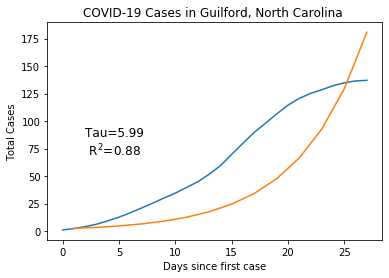

New Hanover County
   index           State       County  Ynot  First Doubling  Current Total  \
0    526  North Carolina  New Hanover     3               4             55   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.162536  6.152467   0.862802       27  37129.0  


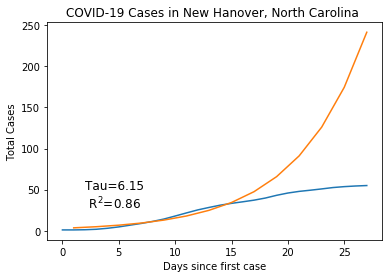

Gaston County
   index           State  County  Ynot  First Doubling  Current Total  \
0    527  North Carolina  Gaston     3               4             86   

   Inv Tau       Tau  R Squared  Days In       ID  
0  0.18825  5.312075   0.933962       27  37071.0  


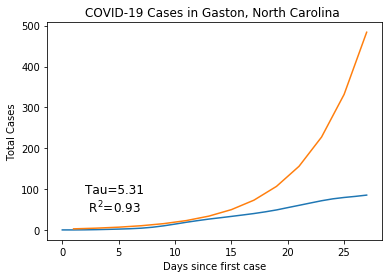

Lincoln County
   index           State   County  Ynot  First Doubling  Current Total  \
0    528  North Carolina  Lincoln     3              11             15   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.137999  7.246431   0.921597       27  37109.0  


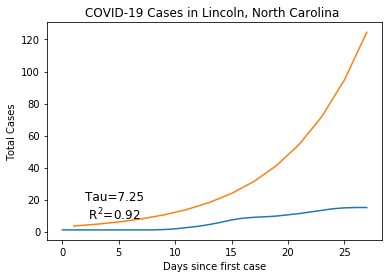

Moore County
   index           State County  Ynot  First Doubling  Current Total  \
0    529  North Carolina  Moore     2               3             66   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.161482  6.192635   0.937966       27  37125.0  


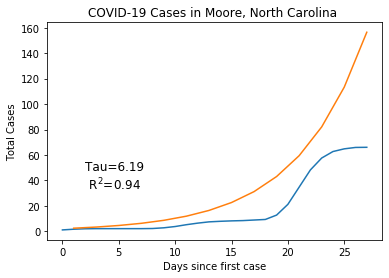

Hoke County
   index           State County  Ynot  First Doubling  Current Total  \
0    530  North Carolina   Hoke     2               8             20   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.135009  7.406909   0.982849       27  37093.0  


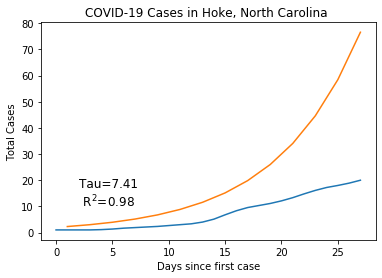

Pitt County
   index           State County  Ynot  First Doubling  Current Total  \
0    531  North Carolina   Pitt     3               2             68   

    Inv Tau      Tau  R Squared  Days In       ID  
0  0.164434  6.08147   0.914781       25  37147.0  


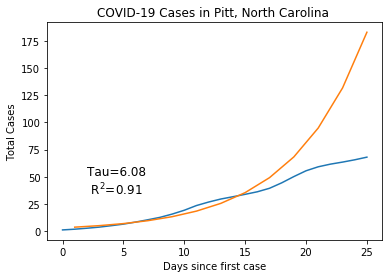

Franklin County
   index           State    County  Ynot  First Doubling  Current Total  \
0    532  North Carolina  Franklin    11              11             66   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.107682  9.286633   0.950749       25  37069.0  


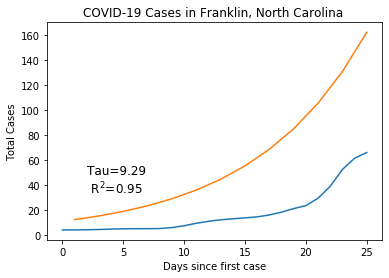

Carteret County
   index           State    County  Ynot  First Doubling  Current Total  \
0    533  North Carolina  Carteret     2               2             22   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.115571  8.652693   0.889922       25  37031.0  


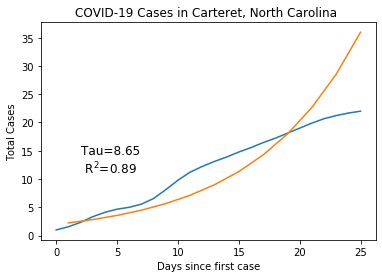

Davidson County
   index           State    County  Ynot  First Doubling  Current Total  \
0    534  North Carolina  Davidson     2               4             86   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.217197  4.604118   0.925318       25  37057.0  


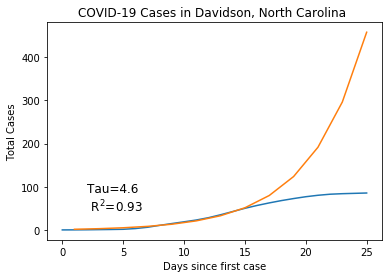

Orange County
   index           State  County  Ynot  First Doubling  Current Total  \
0    535  North Carolina  Orange     6               3            155   

   Inv Tau       Tau  R Squared  Days In       ID  
0  0.15207  6.575937   0.949098       25  37135.0  


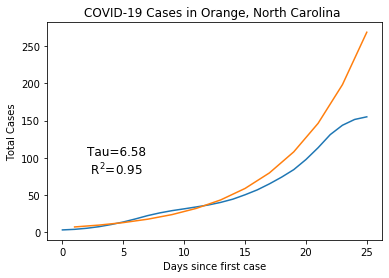

Pasquotank County
   index           State      County  Ynot  First Doubling  Current Total  \
0    536  North Carolina  Pasquotank     2              10             15   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.143171  6.984637   0.935073       25  37139.0  


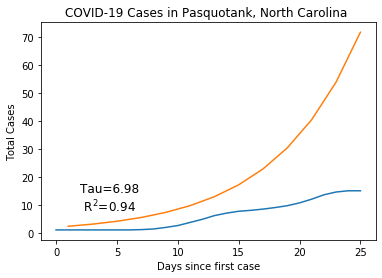

Rowan County
   index           State County  Ynot  First Doubling  Current Total  \
0    537  North Carolina  Rowan     2               2            201   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.195436  5.116754   0.953771       25  37159.0  


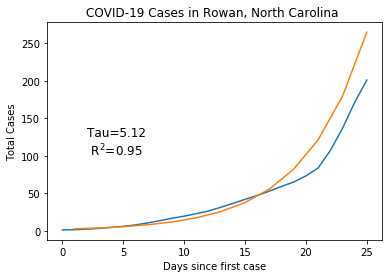

Stanly County
   index           State  County  Ynot  First Doubling  Current Total  \
0    538  North Carolina  Stanly     2               7             17   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.129782  7.705232   0.940248       25  37167.0  


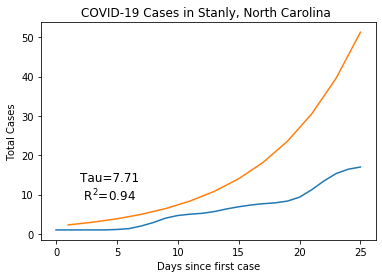

Buncombe County
   index           State    County  Ynot  First Doubling  Current Total  \
0    539  North Carolina  Buncombe     1               2             37   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.125839  7.946681   0.716688       24  37021.0  


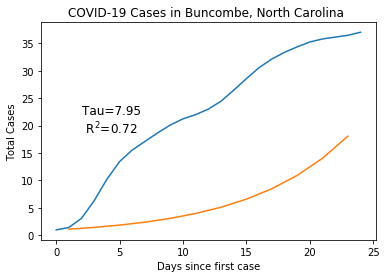

Catawba County
   index           State   County  Ynot  First Doubling  Current Total  \
0    540  North Carolina  Catawba     1               2             35   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.143786  6.954802   0.868564       24  37035.0  


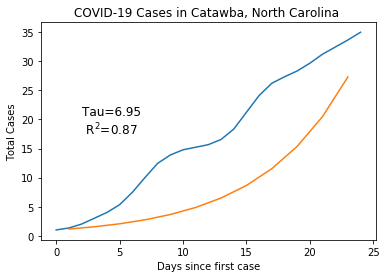

Robeson County
   index           State   County  Ynot  First Doubling  Current Total  \
0    541  North Carolina  Robeson     2               5             10   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.097065  10.302413   0.985974       23  37155.0  


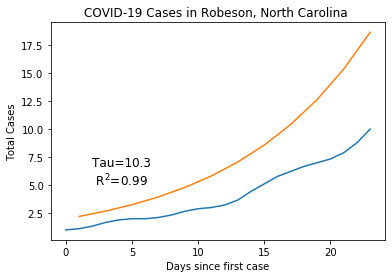

Davie County
   index           State County  Ynot  First Doubling  Current Total  Inv Tau  \
0    542  North Carolina  Davie     2               5             22  0.16499   

        Tau  R Squared  Days In       ID  
0  6.060968   0.859523       23  37059.0  


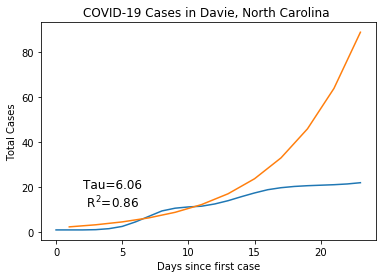

Granville County
   index           State     County  Ynot  First Doubling  Current Total  \
0    543  North Carolina  Granville     3               5             97   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.255312  3.916774   0.968365       23  37077.0  


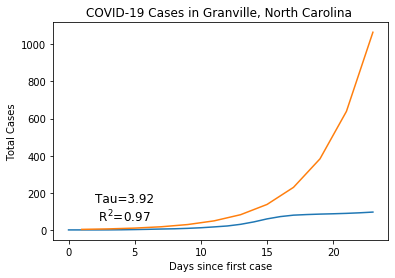

Lee County
   index           State County  Ynot  First Doubling  Current Total  \
0    544  North Carolina    Lee     2               7             14   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.101761  9.826982   0.951131       23  37105.0  


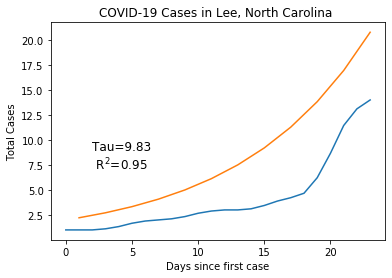

Cherokee County
   index           State    County  Ynot  First Doubling  Current Total  \
0    545  North Carolina  Cherokee     8              11             12   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.051643  19.36388   0.899733       23  37039.0  


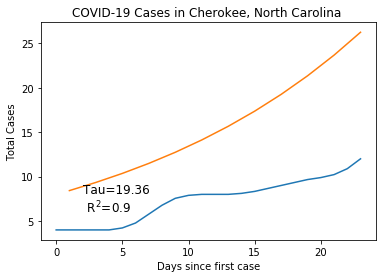

Henderson County
   index           State     County  Ynot  First Doubling  Current Total  \
0    546  North Carolina  Henderson     2               3             97   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.199294  5.017709   0.927522       23  37089.0  


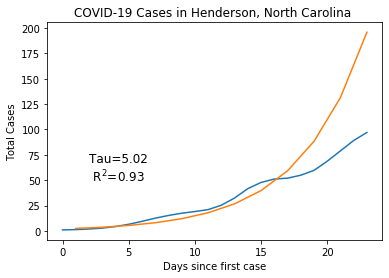

Nash County
   index           State County  Ynot  First Doubling  Current Total  \
0    547  North Carolina   Nash     2               5             39   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.186874  5.351205   0.958565       23  37127.0  


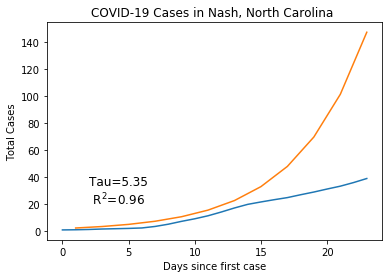

Union County
   index           State County  Ynot  First Doubling  Current Total  \
0    548  North Carolina  Union    24               4            110   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.110748  9.029503   0.940135       23  37179.0  


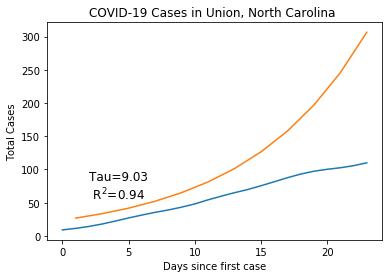

Cumberland County
   index           State      County  Ynot  First Doubling  Current Total  \
0    549  North Carolina  Cumberland     5               3             86   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.180615  5.536643    0.96109       23  37051.0  


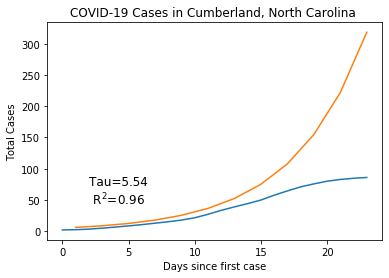

Scotland County
   index           State    County  Ynot  First Doubling  Current Total  \
0    550  North Carolina  Scotland     2               9              9   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.093554  10.68902   0.896519       23  37165.0  


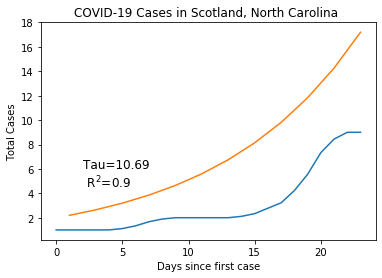

Alamance County
   index           State    County  Ynot  First Doubling  Current Total  \
0    551  North Carolina  Alamance     6               6             73   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.141682  7.058061   0.995624       22  37001.0  


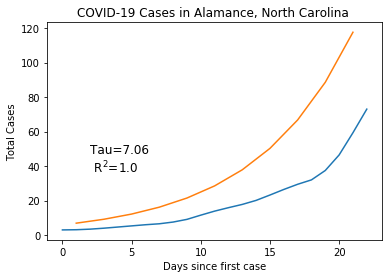

Vance County
   index           State County  Ynot  First Doubling  Current Total  \
0    552  North Carolina  Vance     2               3             21   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.148285  6.743767   0.981687       22  37181.0  


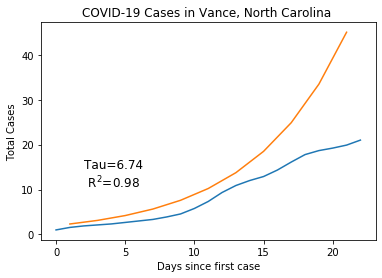

Randolph County
   index           State    County  Ynot  First Doubling  Current Total  \
0    553  North Carolina  Randolph     3               2             55   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.153899  6.497766   0.897467       21  37151.0  


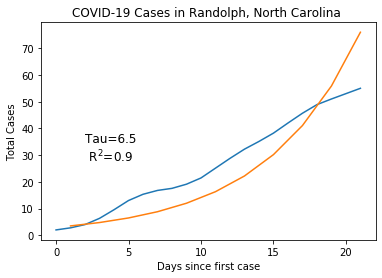

Transylvania County
   index           State        County  Ynot  First Doubling  Current Total  \
0    554  North Carolina  Transylvania     2               2              6   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.077778  12.857047   0.793996       21  37175.0  


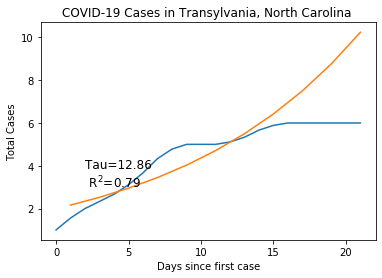

Montgomery County
   index           State      County  Ynot  First Doubling  Current Total  \
0    555  North Carolina  Montgomery     3               2             14   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.117608  8.502796   0.888216       21  37123.0  


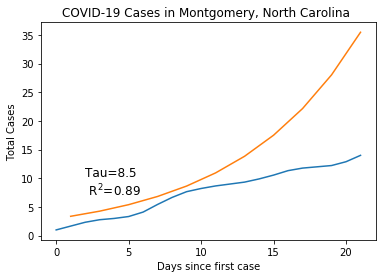

Hertford County
   index           State    County  Ynot  First Doubling  Current Total  \
0    556  North Carolina  Hertford     2               3              4   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.062522  15.99446   0.691336       20  37091.0  


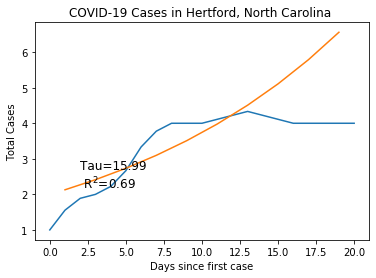

Cleveland County
   index           State     County  Ynot  First Doubling  Current Total  \
0    557  North Carolina  Cleveland     2               2             39   

    Inv Tau      Tau  R Squared  Days In       ID  
0  0.189517  5.27656   0.968404       20  37045.0  


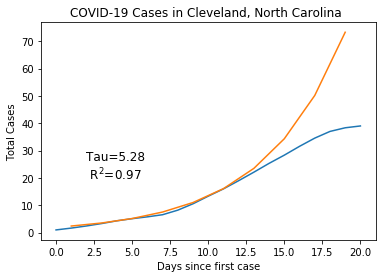

Burke County
   index           State County  Ynot  First Doubling  Current Total  Inv Tau  \
0    558  North Carolina  Burke     5               5             59  0.20982   

        Tau  R Squared  Days In       ID  
0  4.765988   0.993347       20  37023.0  


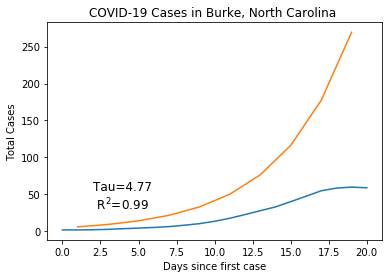

McDowell County
   index           State    County  Ynot  First Doubling  Current Total  \
0    559  North Carolina  McDowell     4               4             18   

   Inv Tau       Tau  R Squared  Days In       ID  
0  0.11261  8.880202   0.954609       20  37111.0  


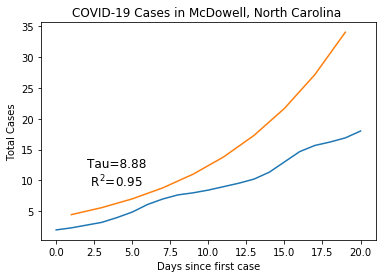

Duplin County
   index           State  County  Ynot  First Doubling  Current Total  \
0    560  North Carolina  Duplin     2               8             19   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.180201  5.549368   0.945829       20  37061.0  


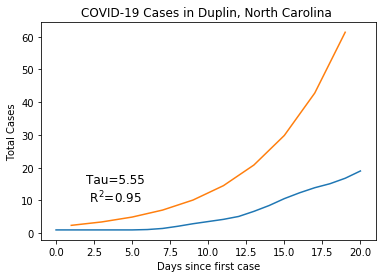

Northampton County
   index           State       County  Ynot  First Doubling  Current Total  \
0    561  North Carolina  Northampton     3               1             63   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.174092  5.744079   0.720523       20  37131.0  


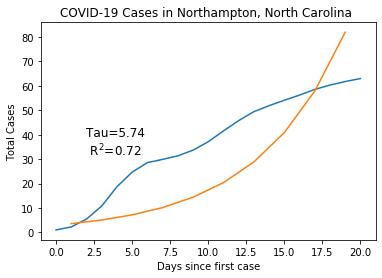

Caldwell County
   index           State    County  Ynot  First Doubling  Current Total  \
0    562  North Carolina  Caldwell     3               1             19   

    Inv Tau     Tau  R Squared  Days In       ID  
0  0.134023  7.4614   0.933086       20  37027.0  


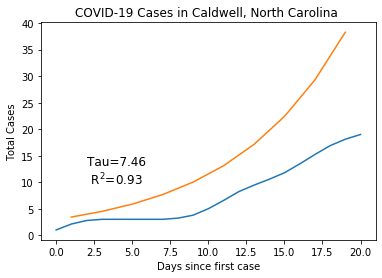

Lenoir County
   index           State  County  Ynot  First Doubling  Current Total  \
0    563  North Carolina  Lenoir     3               1             14   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.129901  7.698189   0.944059       20  37107.0  


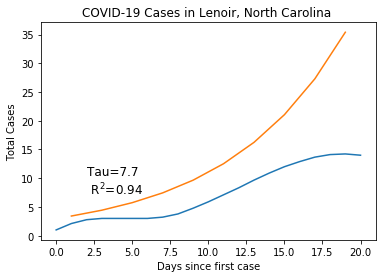

Bertie County
   index           State  County  Ynot  First Doubling  Current Total  \
0    564  North Carolina  Bertie     5               5             15   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.095709  10.448381   0.963404       20  37015.0  


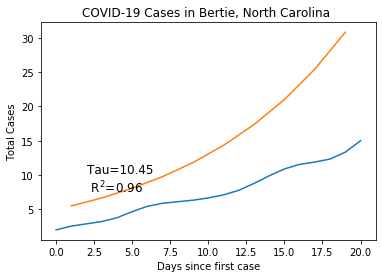

Beaufort County
   index           State    County  Ynot  First Doubling  Current Total  \
0    565  North Carolina  Beaufort     4               5             13   

    Inv Tau      Tau  R Squared  Days In       ID  
0  0.107845  9.27261    0.95929       19  37013.0  


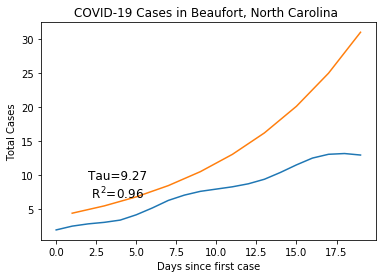

Person County
   index           State  County  Ynot  First Doubling  Current Total  \
0    566  North Carolina  Person     2               6             11   

    Inv Tau    Tau  R Squared  Days In       ID  
0  0.157183  6.362    0.96497       18  37145.0  


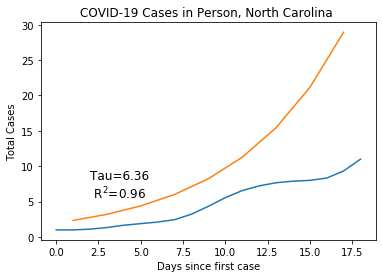

Surry County
   index           State County  Ynot  First Doubling  Current Total  \
0    567  North Carolina  Surry     2               4             10   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.157008  6.369116   0.942064       18  37171.0  


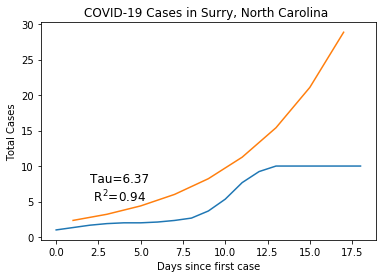

Greene County
   index           State  County  Ynot  First Doubling  Current Total  \
0    568  North Carolina  Greene     6               9             13   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.097045  10.304481   0.932675       18  37079.0  


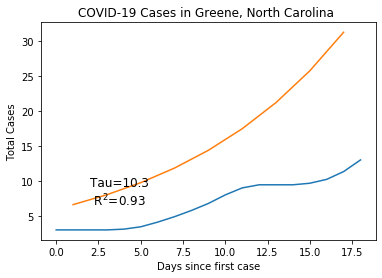

Richmond County
   index           State    County  Ynot  First Doubling  Current Total  \
0    569  North Carolina  Richmond     2              12             12   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.127612  7.836233   0.635376       17  37153.0  


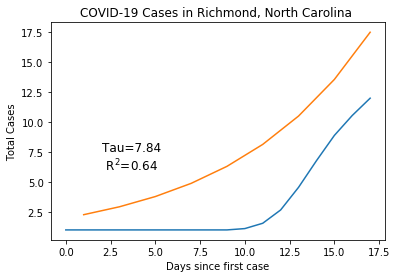

Edgecombe County
   index           State     County  Ynot  First Doubling  Current Total  \
0    570  North Carolina  Edgecombe     3               3             31   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.210805  4.743727   0.990121       17  37065.0  


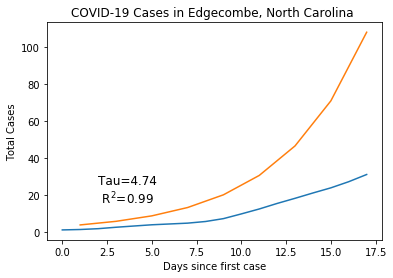

Polk County
   index           State County  Ynot  First Doubling  Current Total  \
0    571  North Carolina   Polk     4               5              9   

    Inv Tau      Tau  R Squared  Days In       ID  
0  0.106124  9.42294   0.904283       17  37149.0  


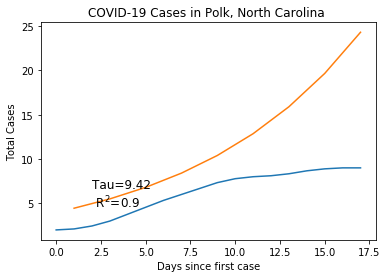

Perquimans County
   index           State      County  Ynot  First Doubling  Current Total  \
0    572  North Carolina  Perquimans     2              10              8   

    Inv Tau     Tau  R Squared  Days In       ID  
0  0.101656  9.8371   0.912525       17  37143.0  


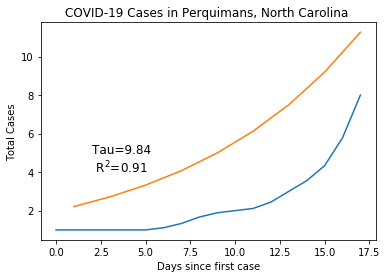

Alleghany County
   index           State     County  Ynot  First Doubling  Current Total  \
0    573  North Carolina  Alleghany     2               3              2   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.023735  42.13245   0.328615       16  37005.0  


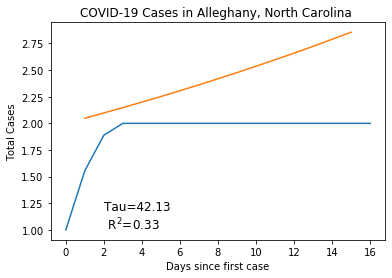

Currituck County
   index           State     County  Ynot  First Doubling  Current Total  \
0    574  North Carolina  Currituck     2               6              3   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.089235  11.206316   0.925773       16  37053.0  


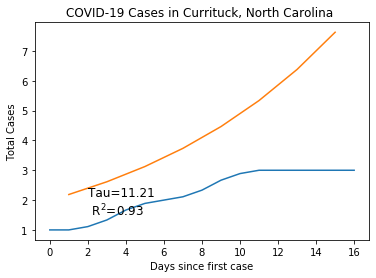

Halifax County
   index           State   County  Ynot  First Doubling  Current Total  \
0    575  North Carolina  Halifax     4               3             25   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.157764  6.338599    0.95138       16  37083.0  


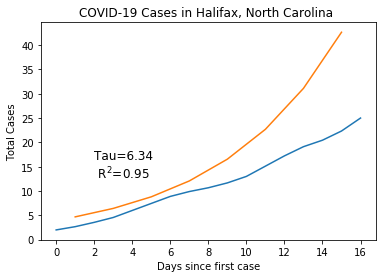

Pamlico County
   index           State   County  Ynot  First Doubling  Current Total  \
0    576  North Carolina  Pamlico     2               5              6   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.125619  7.960584   0.936419       16  37137.0  


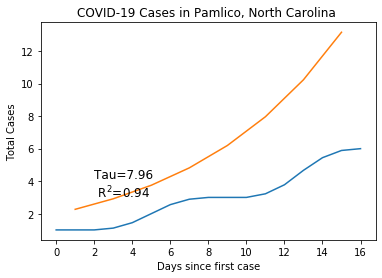

Yadkin County
   index           State  County  Ynot  First Doubling  Current Total  \
0    577  North Carolina  Yadkin     3               2             11   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.144432  6.923682   0.824062       16  37197.0  


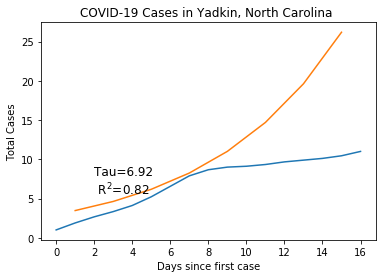

Washington County
   index           State      County  Ynot  First Doubling  Current Total  \
0    578  North Carolina  Washington     2               4             18   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.204189  4.897412   0.991888       16  37187.0  


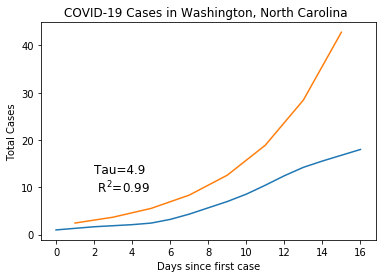

Columbus County
   index           State    County  Ynot  First Doubling  Current Total  \
0    579  North Carolina  Columbus     2               3             37   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.257031  3.890583   0.982388       16  37047.0  


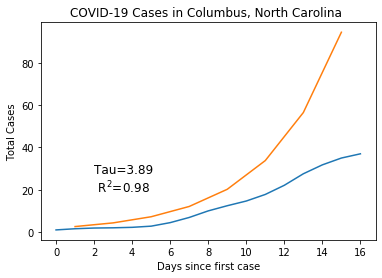

Caswell County
   index           State   County  Ynot  First Doubling  Current Total  \
0    580  North Carolina  Caswell     2               9              3   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.093266  10.722062   0.946333       16  37033.0  


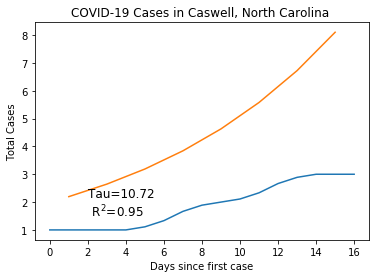

Alexander County
   index           State     County  Ynot  First Doubling  Current Total  \
0    581  North Carolina  Alexander     2               3              3   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.028555  35.019741   0.381957       15  37003.0  


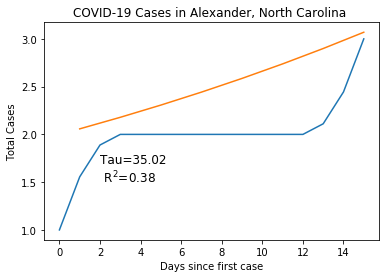

Rutherford County
   index           State      County  Ynot  First Doubling  Current Total  \
0    582  North Carolina  Rutherford     5               1             43   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.217374  4.600361   0.844335       15  37161.0  


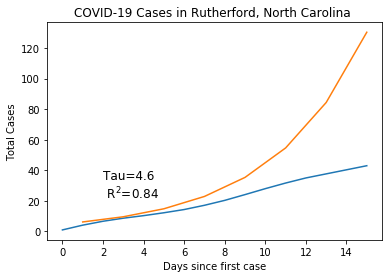

Anson County
   index           State County  Ynot  First Doubling  Current Total  Inv Tau  \
0    583  North Carolina  Anson     3               3             11  0.19809   

        Tau  R Squared  Days In       ID  
0  5.048198    0.93986       14  37007.0  


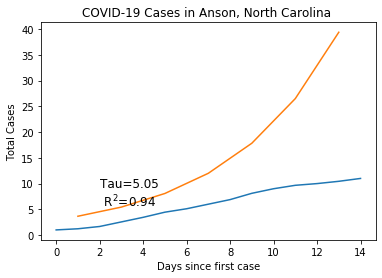

Martin County
   index           State  County  Ynot  First Doubling  Current Total  \
0    584  North Carolina  Martin     4               8              7   

   Inv Tau        Tau  R Squared  Days In       ID  
0  0.08067  12.396127   0.986489       14  37117.0  


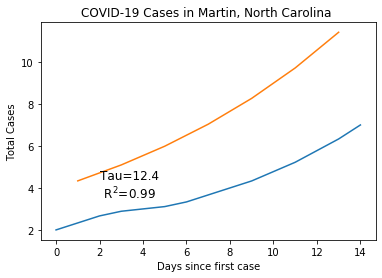

Clay County
   index           State County  Ynot  First Doubling  Current Total  \
0    585  North Carolina   Clay     2               2              3   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.073558  13.594749   0.610319       14  37043.0  


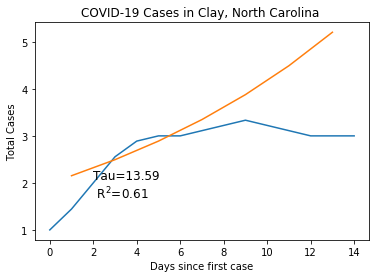

Wilkes County
   index           State  County  Ynot  First Doubling  Current Total  \
0    586  North Carolina  Wilkes     4               4              4   

    Inv Tau        Tau  R Squared  Days In       ID  
0  0.038939  25.680932   0.507626       14  37193.0  


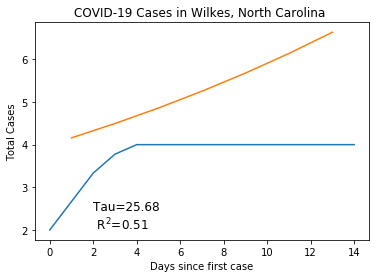

Rockingham County
   index           State      County  Ynot  First Doubling  Current Total  \
0    587  North Carolina  Rockingham     2               2             16   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.199399  5.015076   0.928464       14  37157.0  


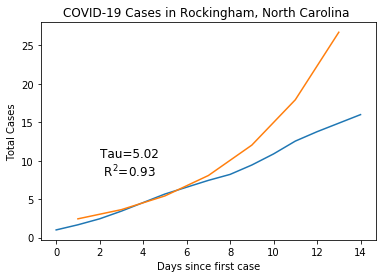

Dare County
   index           State County  Ynot  First Doubling  Current Total  \
0    588  North Carolina   Dare     1               3             12   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.272871  3.664739   0.943459       12  37055.0  


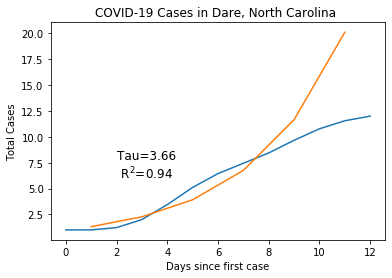

Mitchell County
   index           State    County  Ynot  First Doubling  Current Total  \
0    589  North Carolina  Mitchell     2               5              4   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.165061  6.058364   0.948631       12  37121.0  


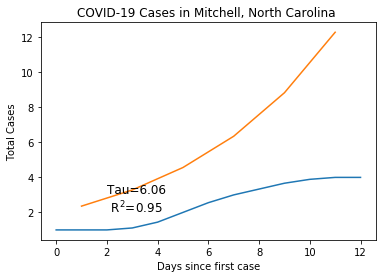

Gates County
   index           State County  Ynot  First Doubling  Current Total  \
0    590  North Carolina  Gates     2               5              4   

    Inv Tau       Tau  R Squared  Days In       ID  
0  0.177913  5.620714   0.924853       12  37073.0  


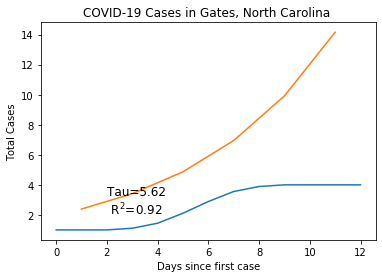

Bladen County
Empty DataFrame
Columns: [index, State, County, Ynot, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


IndexError: index out of bounds

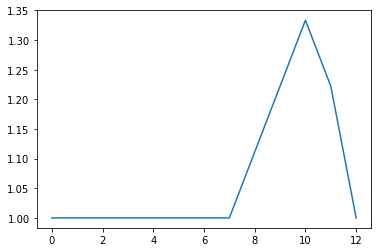

In [22]:
y=0
for x in test:
    print(f'{x} County')
    y=y+1
    df4 = direct_df.loc[(direct_df['County']==x)&(direct_df['State']==state)]
    df4 = df4.reset_index()
    print(df4)
    plt.plot(test[x]['xval'],test[x]['casesII'])
    invtau=df4['Inv Tau'][0]
    ynot = df4['Ynot'][0]
    xval = np.arange(1,len(test[x]['xval']),2)
    yval = ynot*np.exp(xval*invtau)
    plt.plot(xval,yval)
    rsqr=df4['R Squared'][0]
    tau=df4['Tau'][0]
    plt.annotate(f'Tau={round(tau,2)}\n R$^2$={round(rsqr,2)}',(2,max(test[x]['casesII'])/2)).set_fontsize(12)
    plt.title(f'COVID-19 Cases in {x}, {state} ')
    plt.xlabel('Days since first case')
    plt.ylabel('Total Cases')
    plt.savefig(f'../output_data/countyspreadimages/{y}_{x}{state}.png')
    plt.show()

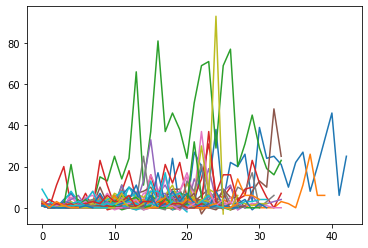

In [23]:
test = exponential[state]
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['delta'])
plt.show()

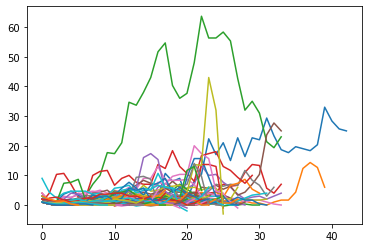

In [24]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaI'])
plt.show()

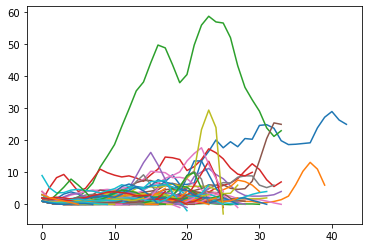

In [25]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaII'])
plt.show()

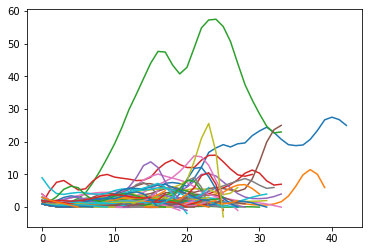

In [26]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaIII'])
plt.show()

Wake County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
162  North Carolina   Wake              16          25  0.114852  8.706845   

     R Squared       ID  
162   0.876873  37183.0  


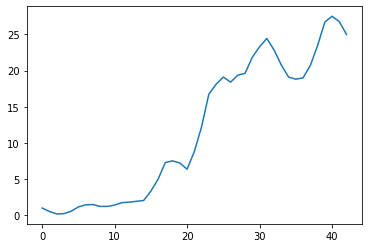

Chatham County
              State   County  First Doubling  Last Delta  Inv Tau  Tau  \
163  North Carolina  Chatham              35           6      0.0  0.0   

     R Squared       ID  
163        0.0  37037.0  


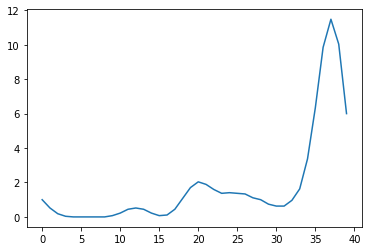

Mecklenburg County
              State       County  First Doubling  Last Delta   Inv Tau  \
164  North Carolina  Mecklenburg               6          23  0.116375   

         Tau  R Squared       ID  
164  8.59293   0.652283  37119.0  


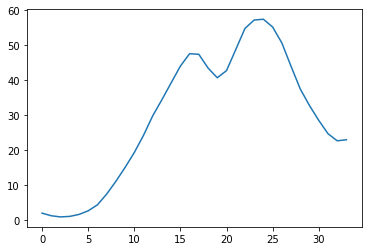

Johnston County
              State    County  First Doubling  Last Delta   Inv Tau       Tau  \
165  North Carolina  Johnston              23           7  0.132428  7.551281   

     R Squared       ID  
165   0.590134  37101.0  


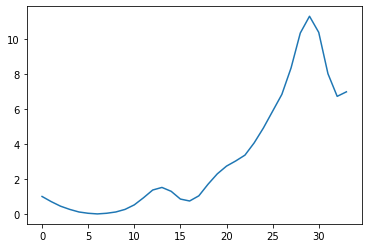

Forsyth County
              State   County  First Doubling  Last Delta   Inv Tau        Tau  \
166  North Carolina  Forsyth              16           4  0.072727  13.750103   

     R Squared       ID  
166   0.343853  37067.0  


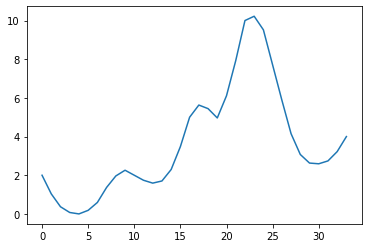

Cabarrus County
              State    County  First Doubling  Last Delta   Inv Tau       Tau  \
167  North Carolina  Cabarrus              15          25  0.130882  7.640458   

     R Squared       ID  
167   0.570194  37025.0  


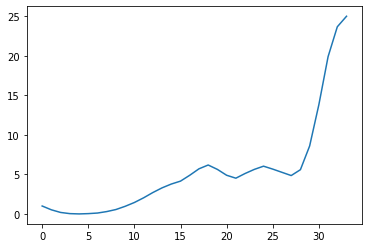

Onslow County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


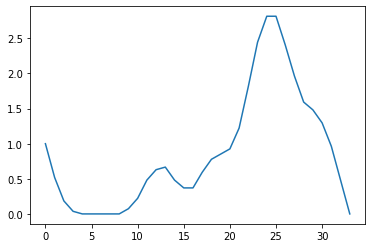

Wayne County
              State County  First Doubling  Last Delta   Inv Tau        Tau  \
168  North Carolina  Wayne              23           6  0.090156  11.091899   

     R Squared       ID  
168   0.202873  37191.0  


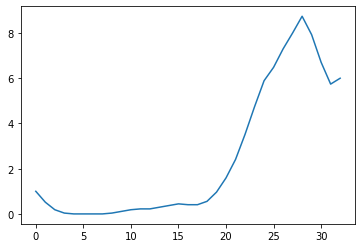

Craven County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


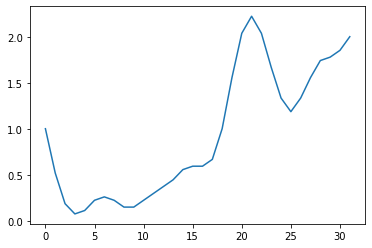

Harnett County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


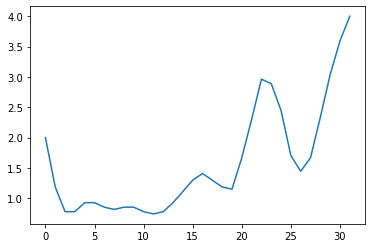

Brunswick County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


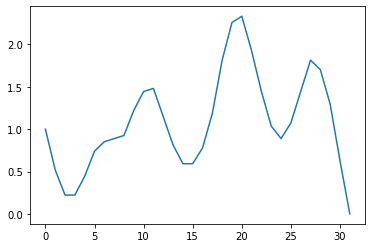

Wilson County
              State  County  First Doubling  Last Delta   Inv Tau      Tau  \
169  North Carolina  Wilson              25           4  0.117014  8.54596   

     R Squared       ID  
169   0.864197  37195.0  


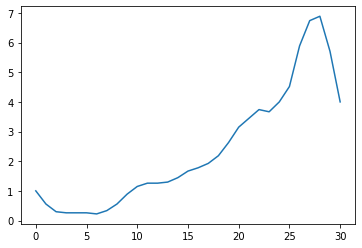

Watauga County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


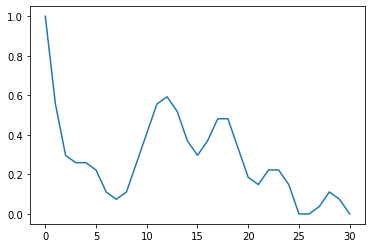

Durham County
              State  County  First Doubling  Last Delta   Inv Tau        Tau  \
170  North Carolina  Durham               1          10  0.047398  21.097891   

     R Squared       ID  
170   0.526492  37063.0  


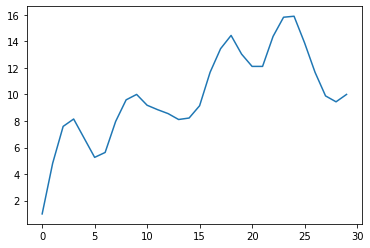

Sampson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


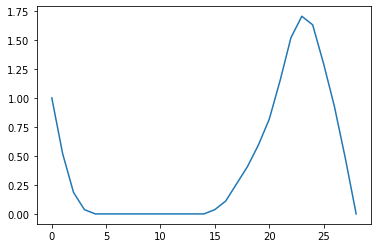

Iredell County
              State   County  First Doubling  Last Delta   Inv Tau        Tau  \
171  North Carolina  Iredell              17           1  0.061599  16.233971   

     R Squared       ID  
171   0.684219  37097.0  


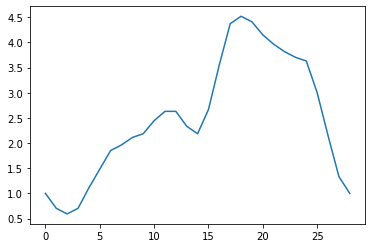

Guilford County
              State    County  First Doubling  Last Delta   Inv Tau  \
172  North Carolina  Guilford               7          -1  0.046145   

           Tau  R Squared       ID  
172  21.670634   0.326928  37081.0  


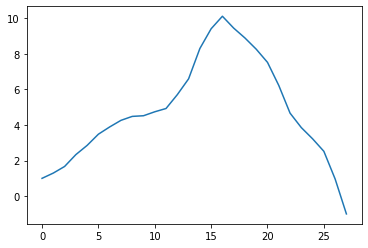

New Hanover County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


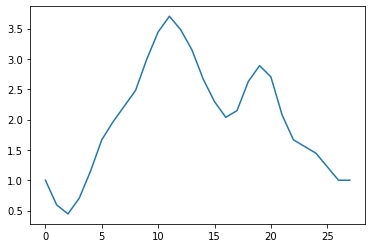

Gaston County
              State  County  First Doubling  Last Delta   Inv Tau        Tau  \
173  North Carolina  Gaston              10           6  0.096712  10.339978   

     R Squared       ID  
173   0.734295  37071.0  


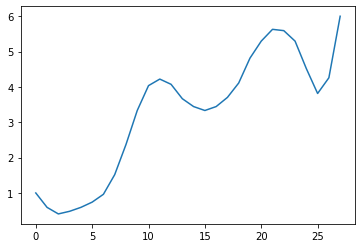

Lincoln County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


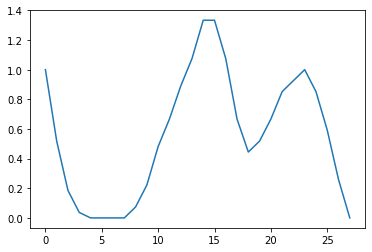

Moore County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
174  North Carolina  Moore              19           0  0.116207  8.605301   

     R Squared       ID  
174   0.273748  37125.0  


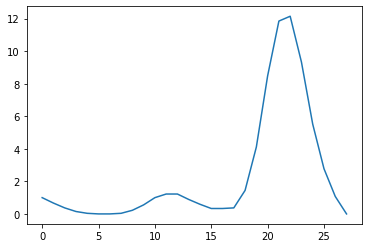

Hoke County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


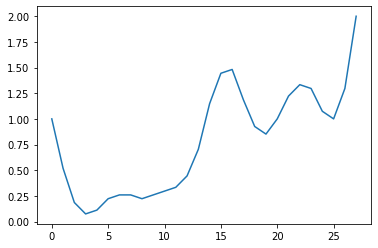

Pitt County
              State County  First Doubling  Last Delta  Inv Tau        Tau  \
175  North Carolina   Pitt              18           3  0.05804  17.229361   

     R Squared       ID  
175   0.617968  37147.0  


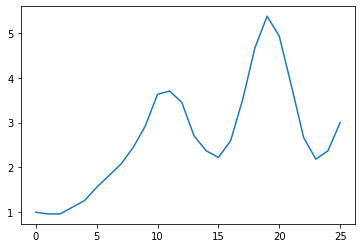

Franklin County
              State    County  First Doubling  Last Delta  Inv Tau  Tau  \
176  North Carolina  Franklin              21          -1      0.0  0.0   

     R Squared       ID  
176        0.0  37069.0  


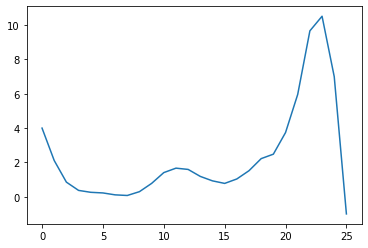

Carteret County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


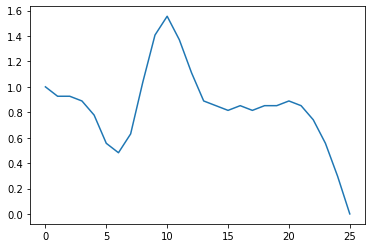

Davidson County
              State    County  First Doubling  Last Delta   Inv Tau  \
177  North Carolina  Davidson               9           2  0.092465   

           Tau  R Squared       ID  
177  10.814859   0.424667  37057.0  


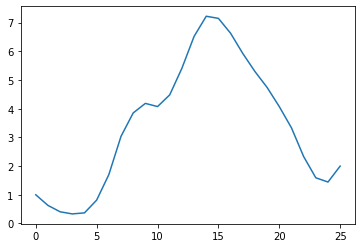

Orange County
              State  County  First Doubling  Last Delta   Inv Tau        Tau  \
178  North Carolina  Orange               7           4  0.084579  11.823216   

     R Squared       ID  
178   0.801905  37135.0  


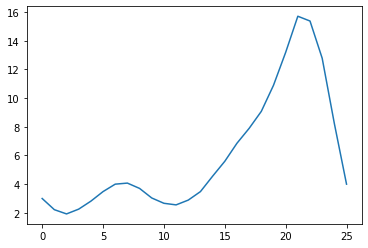

Pasquotank County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


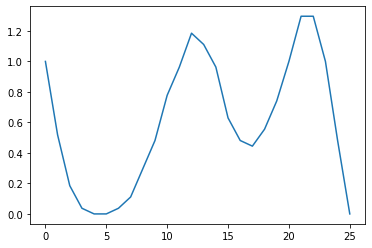

Rowan County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
179  North Carolina  Rowan              13          -3  0.131064  7.629842   

     R Squared       ID  
179   0.946633  37159.0  


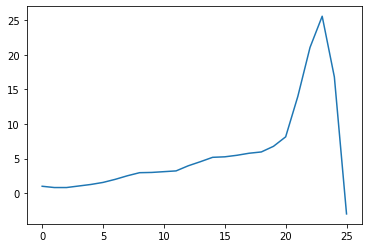

Stanly County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


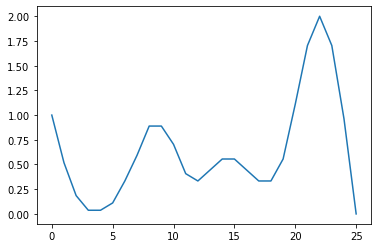

Buncombe County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


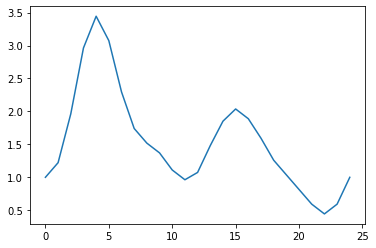

Catawba County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


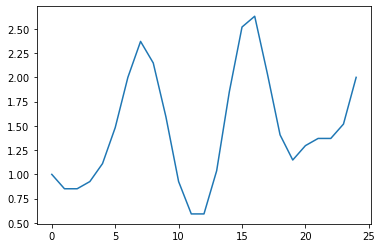

Robeson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


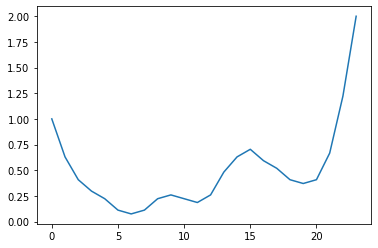

Davie County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


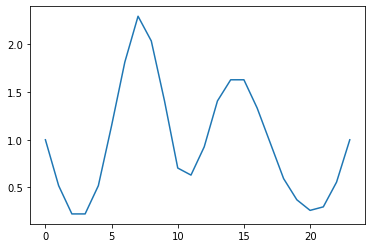

Granville County
              State     County  First Doubling  Last Delta   Inv Tau  \
180  North Carolina  Granville              11           5  0.131319   

          Tau  R Squared       ID  
180  7.615022   0.525743  37077.0  


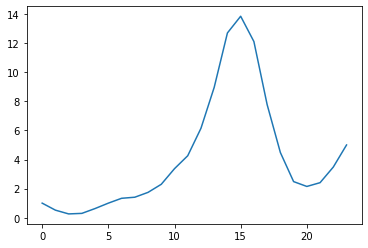

Lee County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


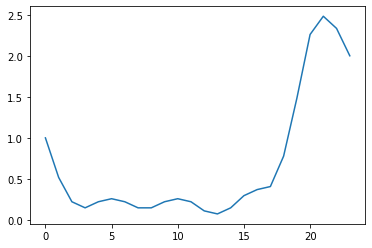

Cherokee County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


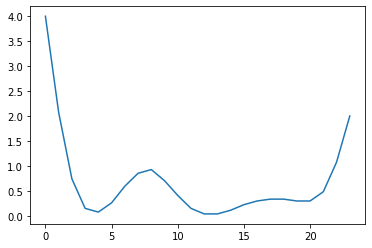

Henderson County
              State     County  First Doubling  Last Delta   Inv Tau  \
181  North Carolina  Henderson              12           0  0.096817   

           Tau  R Squared       ID  
181  10.328761   0.709024  37089.0  


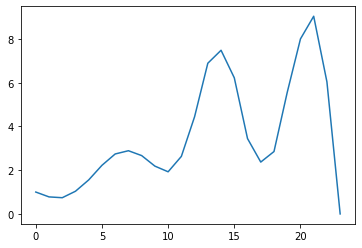

Nash County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


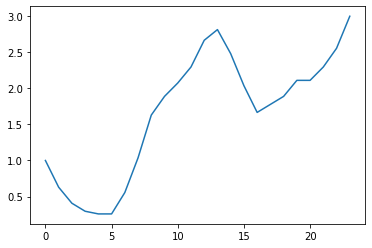

Union County
              State County  First Doubling  Last Delta   Inv Tau         Tau  \
182  North Carolina  Union               1           6 -0.009783 -102.216977   

     R Squared       ID  
182   0.068784  37179.0  


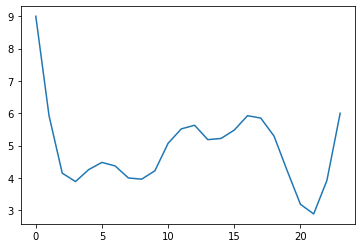

Cumberland County
              State      County  First Doubling  Last Delta   Inv Tau  \
183  North Carolina  Cumberland              11           2  0.072189   

           Tau  R Squared       ID  
183  13.852515   0.672309  37051.0  


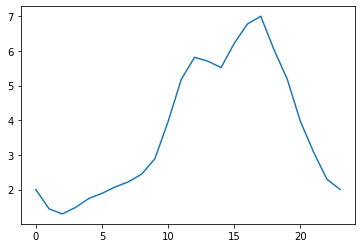

Scotland County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


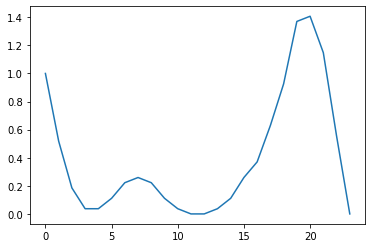

Alamance County
              State    County  First Doubling  Last Delta  Inv Tau  Tau  \
184  North Carolina  Alamance              19           5      0.0  0.0   

     R Squared       ID  
184        0.0  37001.0  


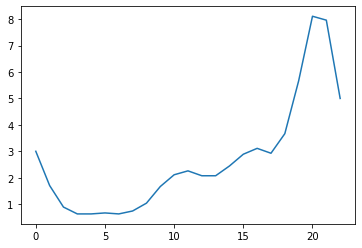

Vance County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


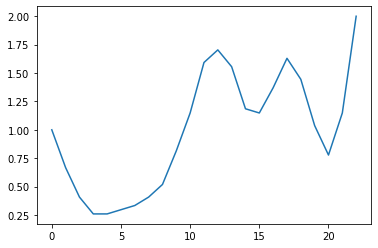

Randolph County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


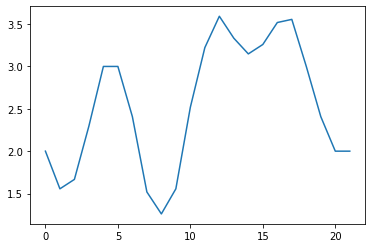

Transylvania County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


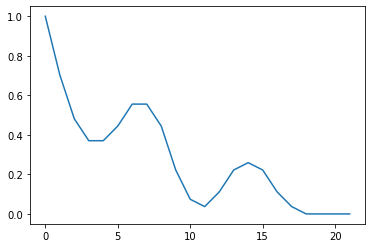

Montgomery County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


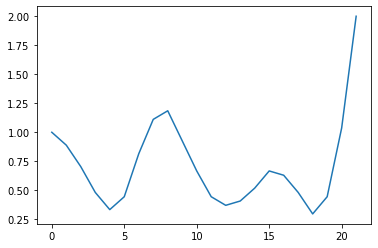

Hertford County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


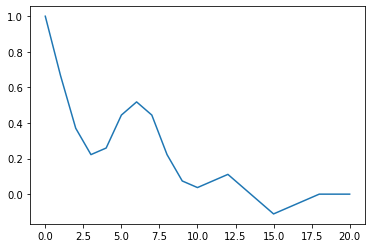

Cleveland County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


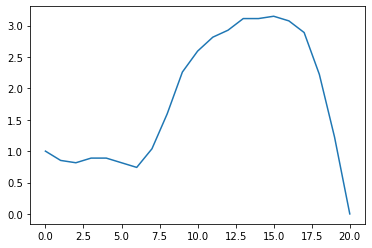

Burke County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
185  North Carolina  Burke              11          -2  0.133996  7.462902   

     R Squared       ID  
185   0.754989  37023.0  


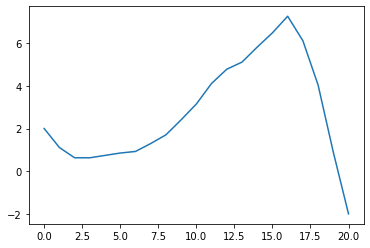

McDowell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


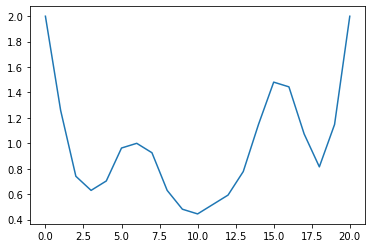

Duplin County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


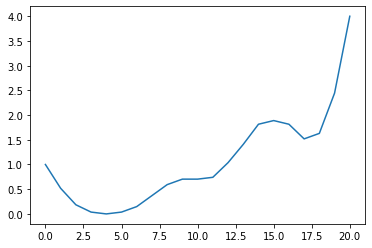

Northampton County
              State       County  First Doubling  Last Delta   Inv Tau  \
186  North Carolina  Northampton               3           2 -0.007758   

            Tau  R Squared       ID  
186 -128.898414   0.008356  37131.0  


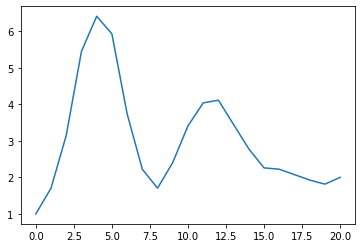

Caldwell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


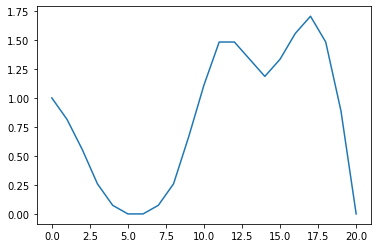

Lenoir County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


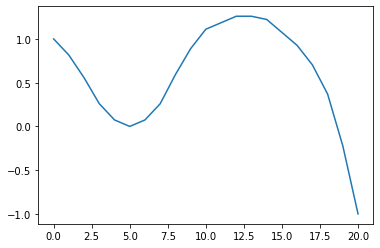

Bertie County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


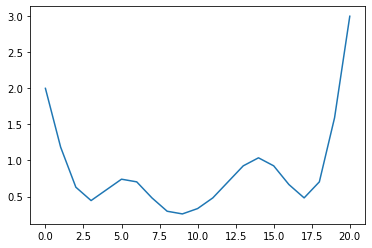

Beaufort County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


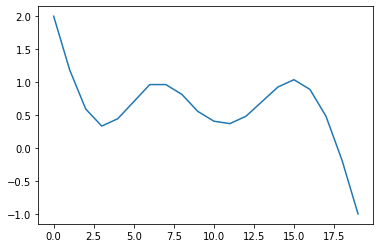

Person County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


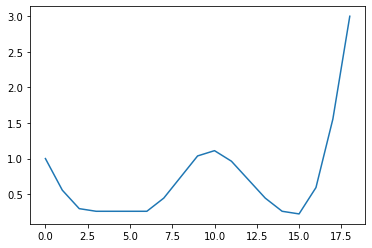

Surry County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


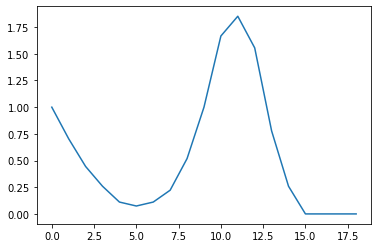

Greene County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


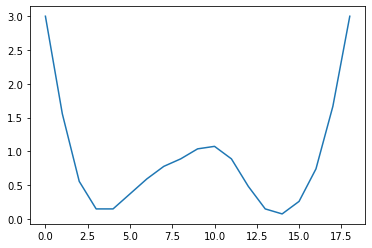

Richmond County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


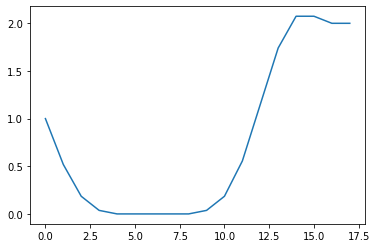

Edgecombe County
              State     County  First Doubling  Last Delta  Inv Tau  Tau  \
187  North Carolina  Edgecombe              17           5      0.0  0.0   

     R Squared       ID  
187        0.0  37065.0  


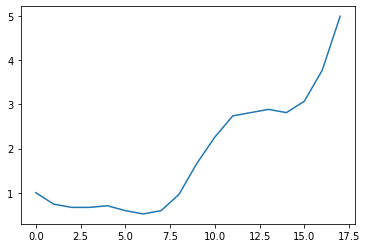

Polk County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


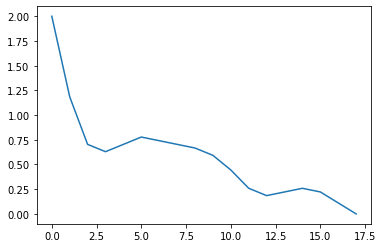

Perquimans County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


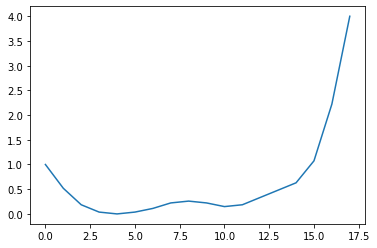

Alleghany County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


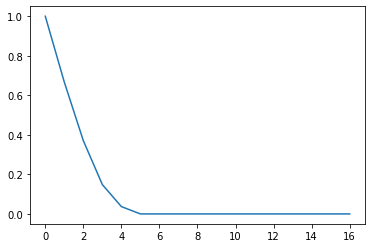

Currituck County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


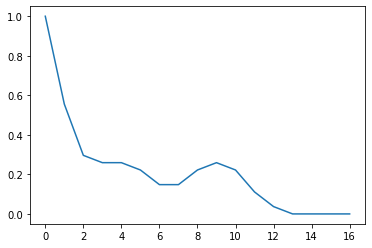

Halifax County
              State   County  First Doubling  Last Delta  Inv Tau  Tau  \
188  North Carolina  Halifax              16           5      0.0  0.0   

     R Squared       ID  
188        0.0  37083.0  


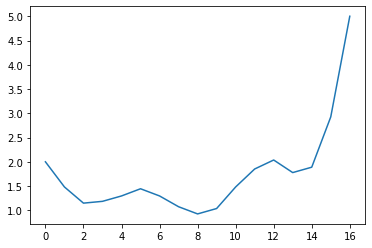

Pamlico County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


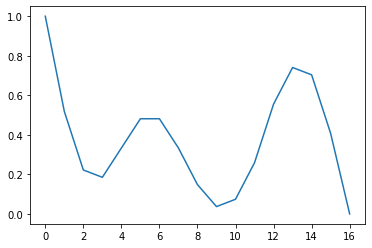

Yadkin County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


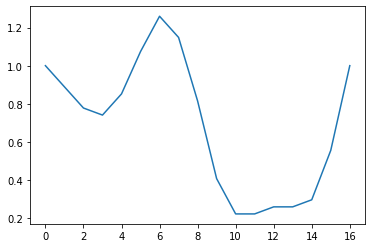

Washington County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


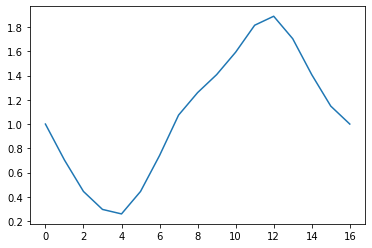

Columbus County
              State    County  First Doubling  Last Delta  Inv Tau  Tau  \
189  North Carolina  Columbus              12           0      0.0  0.0   

     R Squared       ID  
189        0.0  37047.0  


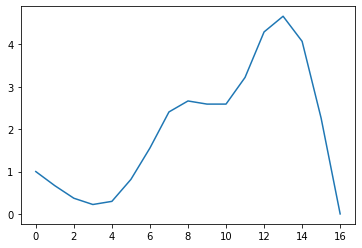

Caswell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


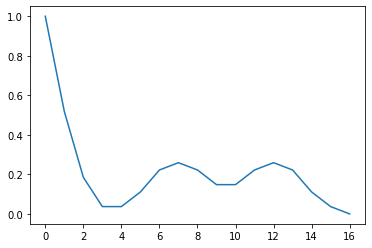

Alexander County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


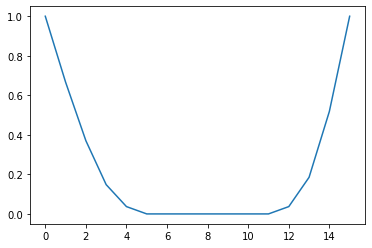

Rutherford County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


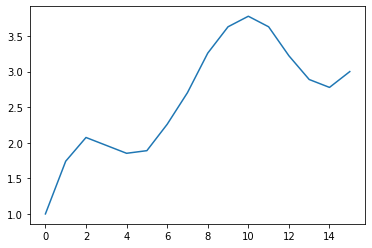

Anson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


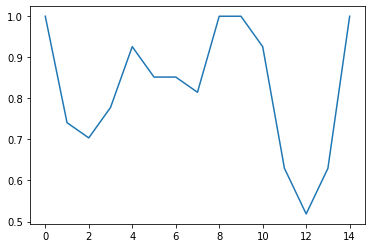

Martin County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


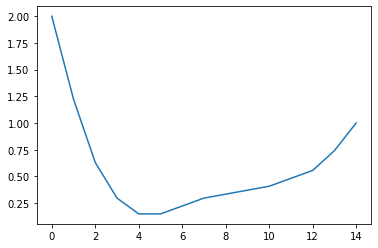

Clay County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


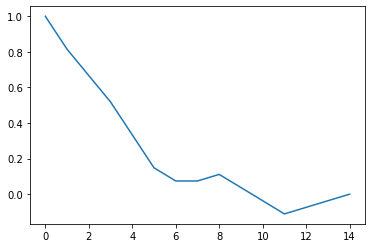

Wilkes County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


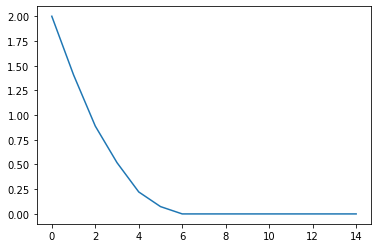

Rockingham County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


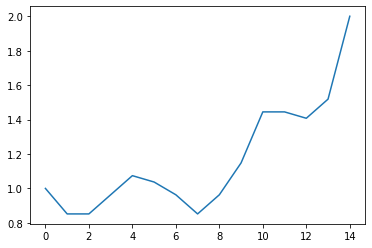

Dare County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


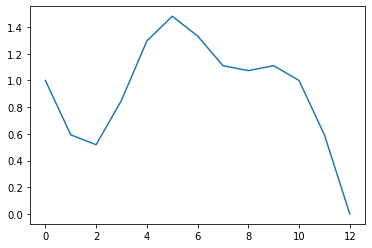

Mitchell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


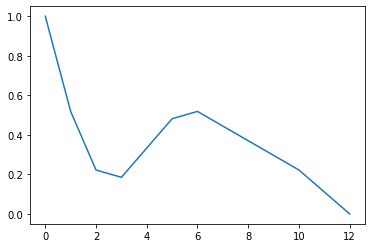

Gates County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


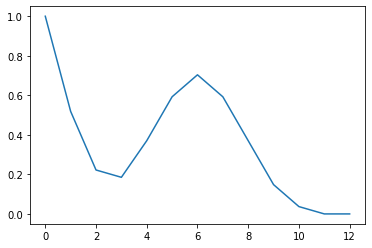

Bladen County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


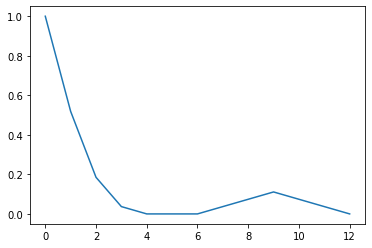

Stokes County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


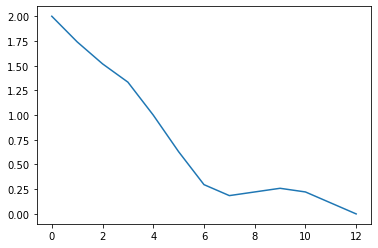

Macon County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


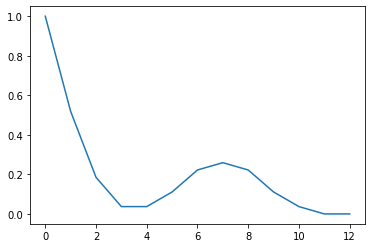

Chowan County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


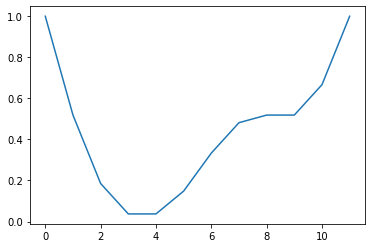

Haywood County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


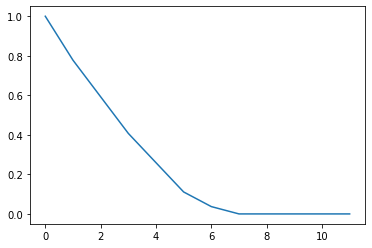

Ashe County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


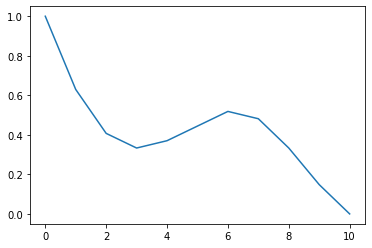

Warren County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


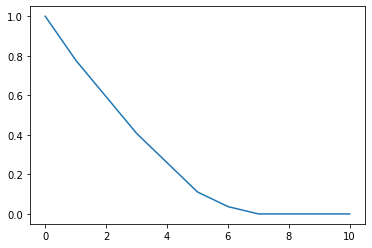

Pender County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


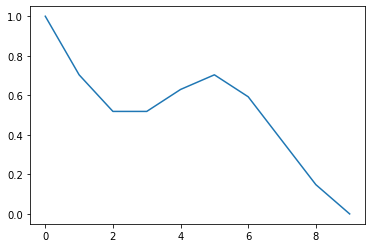

Jackson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


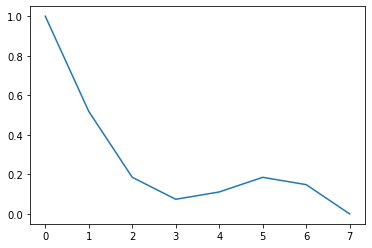

Jones County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


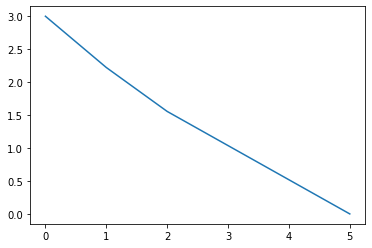

Tyrrell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


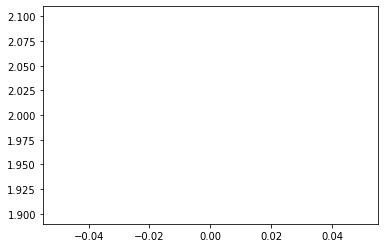

In [27]:
for x in test:
    print(f'{x} County')
    df4 = deriv_df.loc[(deriv_df['County']==x)&(deriv_df['State']==state)]
    print(df4)
    plt.plot(test[x]['xval'],test[x]['deltaIII'])
    plt.show()


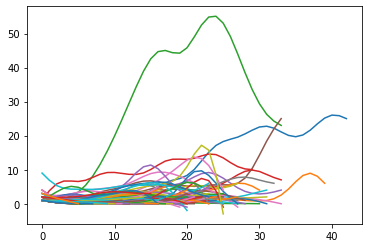

In [28]:
for x in test:
     if len(test[x]['deltaIIIIII']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaIIIIII'])
plt.show()